In [1]:
# Import necessary libraries and modules
import numpy as np
from numpy import pi, random
from math import sqrt, atan2, cos, sin, pow
from qiskit import *
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.extensions import *

In [2]:
def GHZ_Channel(Quantum_Circuit,q1,q2,q3):
    Quantum_Circuit.h(q1)
    Quantum_Circuit.cx(q1,q2)
    Quantum_Circuit.cx(q1,q3)

    return Quantum_Circuit

In [3]:
def BELL_Channel(Quantum_Circuit,q1,q2):
    Quantum_Circuit.h(q1)
    Quantum_Circuit.cx(q1,q2)

    return Quantum_Circuit

In [4]:
# Define desired states
# Alice Input state
theta_A = pi/4
a0 = cos(theta_A)
a1 = sin(theta_A)

# Bob Input state
theta_B = pi/6
b0 = cos(theta_B)
b1 = sin(theta_B)

# Define Classica and Quantum bits
# Alice Side
# q_A[0]=|A1⟩
# q_a[0]=|a1⟩, q_a[1]=|a2⟩
q_A = QuantumRegister(1, 'q_A')
q_a = QuantumRegister(2, 'q_a')

# Bob Side
# q_B[0]=|B1⟩
# q_b[0]=|b1⟩, q_b[1]=|b2⟩
q_B = QuantumRegister(1, 'q_B')
q_b = QuantumRegister(2, 'q_b')

# Charlie Side
# q_C_A[0]=|CA1⟩
# q_C_B[0]=|CB1⟩
q_C_A = QuantumRegister(1, 'q_C_A')
q_C_B = QuantumRegister(1, 'q_C_B')

# First Hop
# q_h1[0]=|h1_1⟩, q_h1[1]=|h1_2⟩, q_h1[2]=|h'1_1⟩, q_h1[3]=|h'1_2⟩
q_h1 = QuantumRegister(4, 'q_h1')

# Second Hop
# q_h2[0]=|h2_1⟩, q_h2[1]=|h2_2⟩, q_h2[2]=|h'2_1⟩, q_h2[3]=|h'2_2⟩
q_h2 = QuantumRegister(4, 'q_h2')

# Classic bits: 
# M[0]=|A1⟩,  M[1]=|a1⟩,  M[2]=|B1⟩,  M[3]=|b2⟩,
# M[4]=|h1_1⟩,  M[5]=|h1_2⟩,  M[6]=|h'1_1⟩, M[7]=|h'1_2⟩
# M[8]=|h2_1⟩,  M[9]=|h2_2⟩,  M[10]=|h'2_1⟩, M[11]=|h'2_2⟩
# M[12]=|CA1⟩, M[13]=|CB1⟩, M[14]=|a2⟩, M[15]=|b1⟩
M = ClassicalRegister(16,'m')

# Define Quantum Circuit
QC = QuantumCircuit(q_A,q_B,q_C_A,q_C_B,q_a,q_b,q_h1,q_h2,M)

# Quantum state initialization
QC.initialize([a0,a1],q_A)
QC.initialize([b0,b1],q_B)
QC.barrier()

# Prepare quantum channel
# Quantum GHZ channel between q_a[0]=|a1⟩, q_h1[0]=|h1_1⟩, q_C_A[0]=|CA1⟩
QC = GHZ_Channel(QC,q_a[0],q_h1[0],q_C_A[0])
# Quantum GHZ channel between q_b[1]=|b2⟩, q_h2[2]=|h'2_1⟩, q_C_B[0]=|CB1⟩
QC = GHZ_Channel(QC,q_b[1],q_h2[2],q_C_B[0])

# Quantum BELL channel between q_h1[1]=|h1_2⟩, q_h2[0]=|h2_1⟩
QC = BELL_Channel(QC,q_h1[1],q_h2[0])
# Quantum BELL channel between q_h2[1]=|h2_2⟩, q_b[0]=|b1⟩
QC = BELL_Channel(QC,q_h2[1],q_b[0])
# Quantum BELL channel between q_h2[3]=|h'2_2⟩, q_h1[2]=|h'1_1⟩
QC = BELL_Channel(QC,q_h2[3],q_h1[2])
# Quantum BELL channel between q_h1[3]=|h'1_2⟩, q_a[1]=|a2⟩
QC = BELL_Channel(QC,q_h1[3],q_a[1])
QC.barrier()

# BSM on Alice and Bob's qubits
# BSM M[0]=q_A[0]=|A1⟩,  M[1]=q_a[0]=|a1⟩
QC.cx(q_A[0],q_a[0])
QC.h(q_A[0])
QC.measure(q_A[0],M[0])
QC.measure(q_a[0],M[1])

# BSM M[2]=q_B[0]=|B1⟩,  M[3]=q_b[1]=|b2⟩
QC.cx(q_B[0],q_b[1])
QC.h(q_B[0])
QC.measure(q_B[0],M[2])
QC.measure(q_b[1],M[3])

QC.barrier()

# Apply required gates on Hop's qubits q_h1[0]=|h1_1⟩ and q_h2[2]=|h'2_1⟩
# BSM Results: |A1a1⟩
QC.z(q_h1[0]).c_if(M[0],1)
QC.x(q_h1[0]).c_if(M[1],1)

# BSM Results: |B1b2⟩
QC.z(q_h2[2]).c_if(M[2],1)
QC.x(q_h2[2]).c_if(M[3],1)

QC.barrier()

# BSM on Hop qubits
# BSM M[4]=q_h1[0]=|h1_1⟩,  M[5]=q_h1[1]=|h1_2⟩
QC.cx(q_h1[1],q_h1[0])
QC.h(q_h1[1])
QC.measure(q_h1[1],M[4])
QC.measure(q_h1[0],M[5])

# BSM M[6]=q_h2[3]=|h'2_1⟩,  M[7]=q_h2[2]=|h'2_2⟩
QC.cx(q_h2[3],q_h2[2])
QC.h(q_h2[3])
QC.measure(q_h2[3],M[6])
QC.measure(q_h2[2],M[7])

# Apply required gates on Hop's qubits q_h2[0]=|h2_1⟩ and q_h1[2]=|h'1_1⟩
# BSM Results: |h1_1⟩|h1_2⟩
QC.z(q_h2[0]).c_if(M[4],1)
QC.x(q_h2[0]).c_if(M[5],1)

# BSM Results: |h'2_1⟩|h'2_2⟩
QC.z(q_h1[2]).c_if(M[6],1)
QC.x(q_h1[2]).c_if(M[7],1)

QC.barrier()

# BSM on Hop qubits
# BSM M[8]=q_h2[0]=|h2_1⟩,  M[9]=q_h2[1]=|h2_2⟩
QC.cx(q_h2[1],q_h2[0])
QC.h(q_h2[1])
QC.measure(q_h2[1],M[8])
QC.measure(q_h2[0],M[9])

# BSM M[10]=q_h1[3]=|h'1_1⟩,  M[11]=q_h1[2]=|h'1_2⟩
QC.cx(q_h1[3],q_h1[2])
QC.h(q_h1[3])
QC.measure(q_h1[3],M[10])
QC.measure(q_h1[2],M[11])

# Apply required gates on Alice and Bob's qubits q_b[0]=|b1⟩ and q_a[1]=|a2⟩
# BSM Results: |h2_1⟩|h2_2⟩
QC.z(q_b[0]).c_if(M[8],1)
QC.x(q_b[0]).c_if(M[9],1)

# BSM Results: |h'1_1⟩|h'1_2⟩
QC.z(q_a[1]).c_if(M[10],1)
QC.x(q_a[1]).c_if(M[11],1)

QC.barrier()

# Z-basis Measurement on Charlie's qubits
# M[12]=q_C_A[0]=|CA1⟩,  M[13]=q_C_B[0]=|CB1⟩
QC.h(q_C_A[0])
QC.h(q_C_B[0])
QC.measure(q_C_A[0],M[12])
QC.measure(q_C_B[0],M[13])

QC.barrier()

# Apply required gates on Alice's and Bob's qubits q_a[1]=|a2⟩ and q_b[0]=|b1⟩
# BSM Results: |CA1CB1⟩
QC.z(q_b[0]).c_if(M[12],1)
QC.z(q_a[1]).c_if(M[13],1)

QC.barrier()

# Z-basis measurement on Output qubits q_a[1]=|a2⟩ and q_b[0]=|b1⟩
QC.measure(q_a[1],M[14])
QC.measure(q_b[0],M[15])



QC.draw()

┌─────────────────────────────┐ ░                                ░ »
   q_A: ┤ Initialize(0.70711,0.70711) ├─░────────────────────────────────░─»
        └─┬─────────────────────────┬─┘ ░                                ░ »
   q_B: ──┤ Initialize(0.86603,0.5) ├───░────────────────────────────────░─»
          └─────────────────────────┘   ░           ┌───┐                ░ »
 q_C_A: ────────────────────────────────░───────────┤ X ├────────────────░─»
                                        ░           └─┬─┘     ┌───┐      ░ »
 q_C_B: ────────────────────────────────░─────────────┼───────┤ X ├──────░─»
                                        ░ ┌───┐       │       └─┬─┘      ░ »
 q_a_0: ────────────────────────────────░─┤ H ├──■────■─────────┼────────░─»
                                        ░ └───┘  │              │  ┌───┐ ░ »
 q_a_1: ────────────────────────────────░────────┼──────────────┼──┤ X ├─░─»
                                        ░        │       ┌───┐  │  └─┬─┘ ░ »
 q_b_0: ────────────────────────────────░────────┼───────┤ X ├──┼────┼───░─»
                                        ░ ┌───┐  │       └─┬─┘  │    │   ░ »
 q_b_1: ────────────────────────────────░─┤ H ├──┼────■────┼────■────┼───░─»
                                        ░ └───┘┌─┴─┐  │    │         │   ░ »
q_h1_0: ────────────────────────────────░──────┤ X ├──┼────┼─────────┼───░─»
                                        ░ ┌───┐└───┘  │    │         │   ░ »
q_h1_1: ────────────────────────────────░─┤ H ├──■────┼────┼─────────┼───░─»
                                        ░ └───┘  │    │    │  ┌───┐  │   ░ »
q_h1_2: ────────────────────────────────░────────┼────┼────┼──┤ X ├──┼───░─»
                                        ░ ┌───┐  │    │    │  └─┬─┘  │   ░ »
q_h1_3: ────────────────────────────────░─┤ H ├──┼────┼────┼────┼────■───░─»
                                        ░ └───┘┌─┴─┐  │    │    │        ░ »
q_h2_0: ────────────────────────────────░──────┤ X ├──┼────┼────┼────────░─»
                                        ░ ┌───┐└───┘  │    │    │        ░ »
q_h2_1: ────────────────────────────────░─┤ H ├───────┼────■────┼────────░─»
                                        ░ └───┘     ┌─┴─┐       │        ░ »
q_h2_2: ────────────────────────────────░───────────┤ X ├───────┼────────░─»
                                        ░ ┌───┐     └───┘       │        ░ »
q_h2_3: ────────────────────────────────░─┤ H ├─────────────────■────────░─»
                                        ░ └───┘                          ░ »
  m: 16/═══════════════════════════════════════════════════════════════════»
                                                                           »
«             ┌───┐        ┌─┐    ░                                  »
«   q_A: ──■──┤ H ├────────┤M├────░──────────────────────────────────»
«          │  └───┘┌───┐   └╥┘┌─┐ ░                                  »
«   q_B: ──┼────■──┤ H ├────╫─┤M├─░──────────────────────────────────»
«          │    │  └───┘    ║ └╥┘ ░                                  »
« q_C_A: ──┼────┼───────────╫──╫──░──────────────────────────────────»
«          │    │           ║  ║  ░                                  »
« q_C_B: ──┼────┼───────────╫──╫──░──────────────────────────────────»
«        ┌─┴─┐  │   ┌─┐     ║  ║  ░                                  »
« q_a_0: ┤ X ├──┼───┤M├─────╫──╫──░──────────────────────────────────»
«        └───┘  │   └╥┘     ║  ║  ░                                  »
« q_a_1: ───────┼────╫──────╫──╫──░──────────────────────────────────»
«               │    ║      ║  ║  ░                                  »
« q_b_0: ───────┼────╫──────╫──╫──░──────────────────────────────────»
«             ┌─┴─┐  ║  ┌─┐ ║  ║  ░                                  »
« q_b_1: ─────┤ X ├──╫──┤M├─╫──╫──░──────────────────────────────────»
«             └───┘  ║  └╥┘ ║  ║  ░    ┌───┐                 ┌───┐   »
«q_h1_0: ────────────╫───╫──╫──╫──░────┤ Z ├─────────────────┤ X ├───»
«                    ║   ║  ║  ║  ░

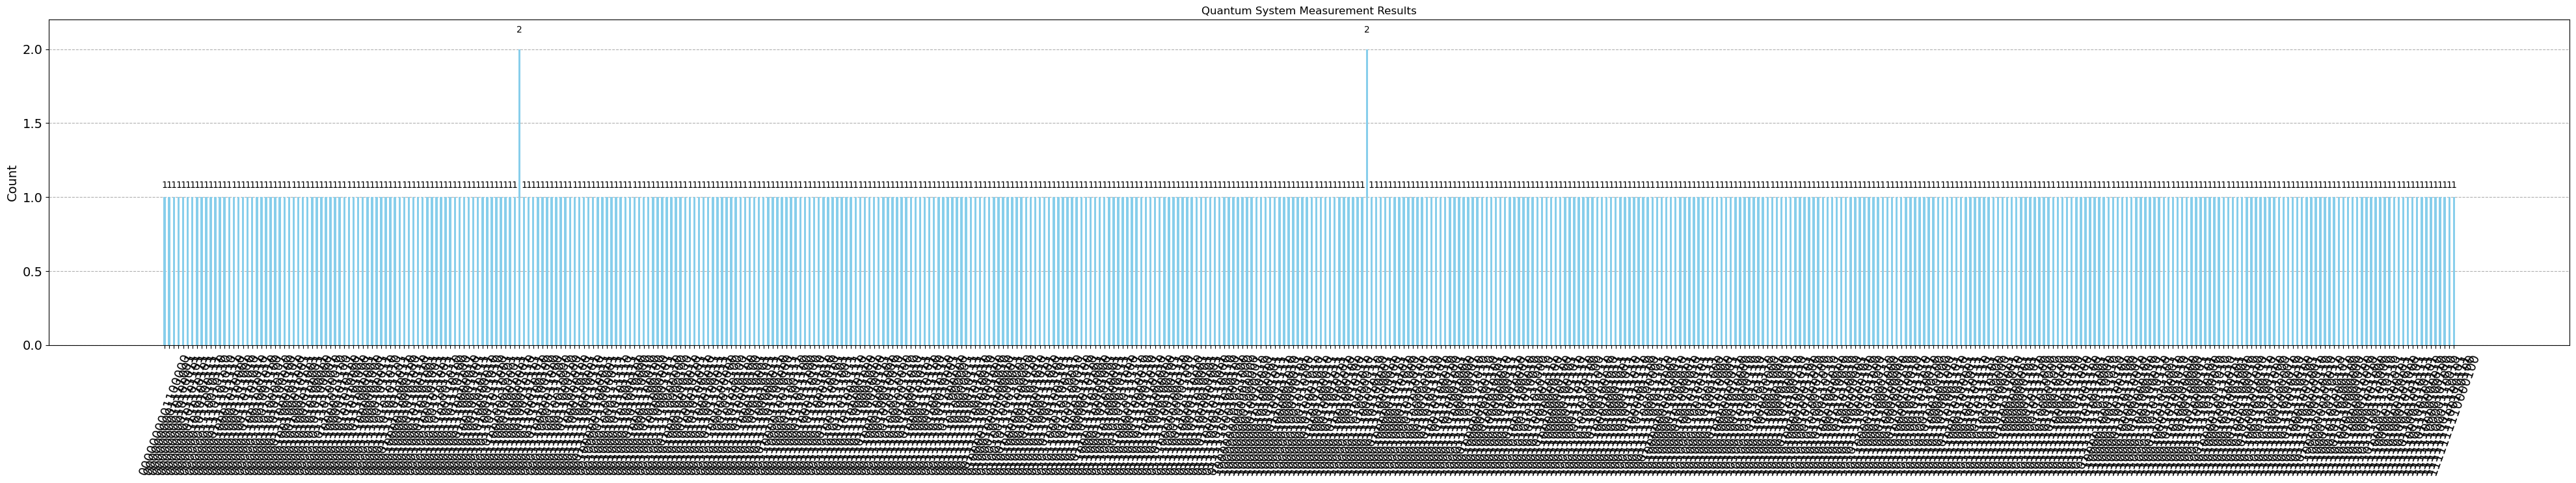

In [115]:
# Set the number of shots for the simulation
m = 500

# Choose the QasmSimulator for the simulation
simulator = QasmSimulator()

# Transpile the quantum circuit for execution on the simulator
circ = transpile(QC, simulator)

# Run the simulation with the specified number of shots
result = simulator.run(circ, shots=m).result()

# Obtain the measurement outcomes and their counts
counts = result.get_counts(circ)

# Display the histogram of measurement outcomes
# You can adjust the figure size using the second argument in plot_histogram
# [20, 6.5] specifies the width and height of the figure
plot_histogram(counts, [50, 6.5],title='Quantum System Measurement Results',color='skyblue')

In [116]:
# Initialize an array to store counts for different states
State_a2 = np.zeros([2])
State_b1 = np.zeros([2])

# Count occurrences of different states based on measurement outcomes
for state in counts:
    if (state[0] == '0') and (state[1] == '0'):
        State_a2[0] = State_a2[0] + counts[state]
        State_b1[0] = State_b1[0] + counts[state]
    if (state[0] == '0') and (state[1] == '1'):
        State_a2[1] = State_a2[1] + counts[state]
        State_b1[0] = State_b1[0] + counts[state]
    if (state[0] == '1') and (state[1] == '0'):
        State_a2[0] = State_a2[0] + counts[state]
        State_b1[1] = State_b1[1] + counts[state]
    if (state[0] == '1') and (state[1] == '1'):
        State_a2[1] = State_a2[1] + counts[state]
        State_b1[1] = State_b1[1] + counts[state]

counts_a2 = {'0': State_a2[0], '1': State_a2[1]}
counts_b1 = {'0': State_b1[0], '1': State_b1[1]}


The Bob input state:
|φ_B> = β0|0> + β1|11>
β0 =  0.8660254037844387
β1 =  0.49999999999999994
P_|0⟩ =  0.7500000000000001
P_|1⟩ =  0.24999999999999994


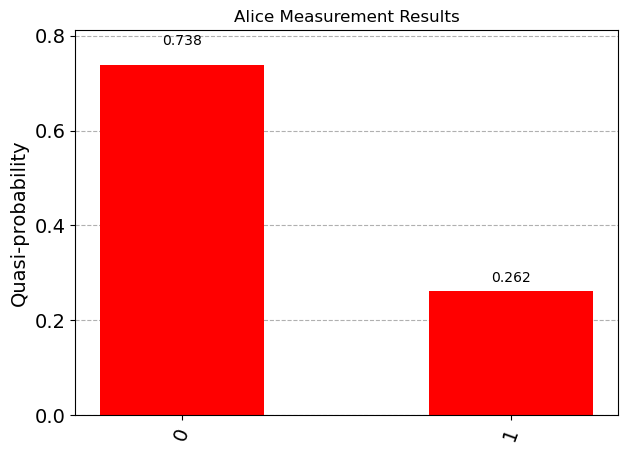

In [117]:
# Display a histogram of measurement outcomes for Alice's qubit
print('The Bob input state:')
print('|φ_B> = β0|0> + β1|11>')
print('β0 = ', cos(theta_B))
print('β1 = ', sin(theta_B))
print('P_|0⟩ = ', pow(cos(theta_B),2))
print('P_|1⟩ = ', pow(sin(theta_B),2))
plot_histogram(counts_a2, title='Alice Measurement Results',color='#FF0000')

The Alice input state:
|φ_A> = α0|0> + α1|11>
α0 =  0.7071067811865476
α1 =  0.7071067811865476
P_|0⟩ =  0.5000000000000001
P_|1⟩ =  0.5000000000000001


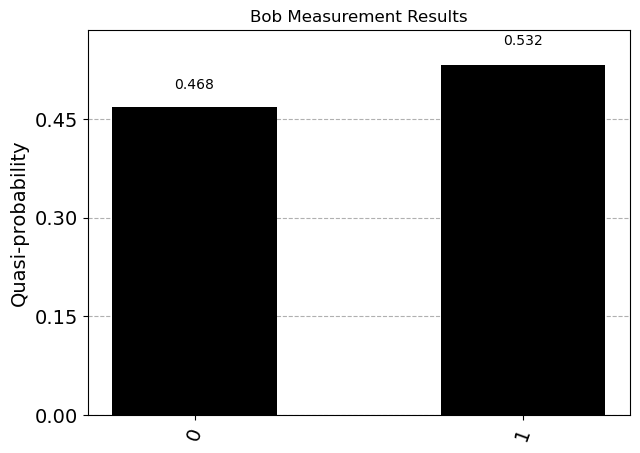

In [118]:
# Display a histogram of measurement outcomes for Bob's qubit
print('The Alice input state:')
print('|φ_A> = α0|0> + α1|11>')
print('α0 = ', cos(theta_A))
print('α1 = ', sin(theta_A))
print('P_|0⟩ = ', pow(cos(theta_A),2))
print('P_|1⟩ = ', pow(sin(theta_A),2))
plot_histogram(counts_b1, title='Bob Measurement Results',color='#000000')